In [ ]:
%matplotlib inline

# Assuming we are in the notebooks directory, we need to move one up:
%cd ..

from __future__ import print_function

import os
import us
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Utah

In [2]:
state_name = 'UT'
best_path = glob.glob('./clustered/best_stats/' + state_name +'*')[0]
best_basename = os.path.basename(best_path)
filename, file_extension = os.path.splitext(best_basename)
state = gpd.read_file(glob.glob('./clustered/geojson_results/' + filename +'.geojson')[0])

In [3]:
state.head()

,Alpha,Beta,Centroid Latitude,Centroid Longitude,Cluster,Congressional District,GEOID,Predicted 2015 Population,geometry,id
0,3.0,0.5,38.215673,-112.532952,3,02,490011001001490,0.0,"POLYGON ((-112.537887 38.214833, -112.537886 3...",0
1,3.0,0.5,38.189881,-112.534329,3,02,490011001001647,0.0,"POLYGON ((-112.514011 38.192667, -112.513672 3...",1
2,3.0,0.5,38.173786,-112.494037,3,02,490011001001599,0.0,"POLYGON ((-112.484921 38.169493, -112.485155 3...",2
3,3.0,0.5,38.157100,-112.555520,3,02,490011001001649,0.0,"POLYGON ((-112.57238 38.168472, -112.572392 38...",3
4,3.0,0.5,38.152430,-112.522103,3,02,490011001001651,0.0,"POLYGON ((-112.521503 38.150862, -112.521679 3...",4


In [4]:
mini = state[['Predicted 2015 Population', 'geometry', 'Cluster', 'Congressional District', 'GEOID']]

In [5]:
mini['area'] = mini['geometry'].to_crs({'init': 'epsg:3395'}).map(lambda p: p.area / 10**6)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [6]:
# GEOID Structure is defined as
# STATE + COUNTY + TRACT + BLOCK = 2 + 3 + 6 + 4 = 15
# see: https://www.census.gov/geo/reference/geoidentifiers.html
def get_tract(row):
#     print(type(row['GEOID']))
    return row['GEOID'][5:11]
mini['Tract'] = mini.apply(get_tract, axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
tracts = mini.dissolve(by='Tract')

In [8]:
tracts.head()

,geometry,Predicted 2015 Population,Cluster,Congressional District,GEOID,area
Tract,,,,,,
000100,"POLYGON ((-110.700944 39.535739, -110.700949 3...",0.000000,3,03,490070001002077,0.016361
000101,"POLYGON ((-111.908744 41.896871, -111.908887 4...",22.080848,0,01,490050001012003,6.336656
000102,"(POLYGON ((-111.864709 40.390995, -111.864765 ...",13.328895,0,01,490050001022049,0.063278
000103,"POLYGON ((-111.867037 40.381302, -111.867039 4...",26.094675,1,04,490490001032006,0.265339
000104,"POLYGON ((-111.841853 40.396634, -111.842187 4...",48.605923,1,03,490490001042004,0.055659


In [9]:
mini = mini[['Predicted 2015 Population', 'area', 'Tract']]

In [10]:
mini.head()

,Predicted 2015 Population,area,Tract
0,0.0,0.023229,100100
1,0.0,8.464858,100100
2,0.0,0.091658,100100
3,0.0,9.475793,100100
4,0.0,0.050850,100100


In [11]:
pop = mini.groupby('Tract').sum()
pop['Tract'] = pop.index
pop.head()

,Predicted 2015 Population,area,Tract
Tract,,,
000100,3881.0,132.603576,000100
000101,4872.0,280.370952,000101
000102,6287.0,398.220615,000102
000103,4032.0,7.755903,000103
000104,2995.0,3.718848,000104


In [12]:
del tracts['Predicted 2015 Population']

In [13]:
del tracts['area']

In [14]:
tracts['Tract'] = tracts.index

In [15]:
tracts.head()

,geometry,Cluster,Congressional District,GEOID,Tract
Tract,,,,,
000100,"POLYGON ((-110.700944 39.535739, -110.700949 3...",3,03,490070001002077,000100
000101,"POLYGON ((-111.908744 41.896871, -111.908887 4...",0,01,490050001012003,000101
000102,"(POLYGON ((-111.864709 40.390995, -111.864765 ...",0,01,490050001022049,000102
000103,"POLYGON ((-111.867037 40.381302, -111.867039 4...",1,04,490490001032006,000103
000104,"POLYGON ((-111.841853 40.396634, -111.842187 4...",1,03,490490001042004,000104


In [16]:
tracts = tracts.merge(pop, on='Tract')

In [17]:
tracts['Population per square km'] = tracts['Predicted 2015 Population'] / tracts['area'] 

In [22]:
tracts.head()

,geometry,Cluster,Congressional District,GEOID,Tract,Predicted 2015 Population,area,Population per square km
0,"POLYGON ((-110.700944 39.535739, -110.700949 3...",3,03,490070001002077,000100,3881.0,132.603576,29.267687
1,"POLYGON ((-111.908744 41.896871, -111.908887 4...",0,01,490050001012003,000101,4872.0,280.370952,17.376978
2,"(POLYGON ((-111.864709 40.390995, -111.864765 ...",0,01,490050001022049,000102,6287.0,398.220615,15.787731
3,"POLYGON ((-111.867037 40.381302, -111.867039 4...",1,04,490490001032006,000103,4032.0,7.755903,519.862102
4,"POLYGON ((-111.841853 40.396634, -111.842187 4...",1,03,490490001042004,000104,2995.0,3.718848,805.356980


In [19]:
tracts.to_file('./fig/shapefile/results/pop_' + state_name + '_by_tract.shp', driver="ESRI Shapefile")

# Major Cities in UT

In [23]:
cities = gpd.read_file('./fig/shapefile/citiesx010g_shp_nt00962/citiesx010g.shp')
# From: https://catalog.data.gov/dataset/usgs-small-scale-dataset-cities-and-towns-of-the-united-states-201403-shapefile

In [24]:
cities.head()

,ANSICODE,COUNTY,COUNTYFIPS,ELEV_IN_FT,ELEV_IN_M,FEATURE,FEATURE2,GNIS_ID,LATITUDE,LONGITUDE,NAME,POP_2010,PopPlLat,PopPlLong,STATE,STATE_FIPS,geometry
0,1036000,Rolette,079,1706.0,520.0,Civil,-999,1028750.0,48.813057,-100.060968,Dunseith,773.0,48.813057,-100.060968,ND,38,POINT (-100.0609678 48.81305690000016)
1,1036174,Rolette,079,1654.0,504.0,Civil,-999,1030349.0,48.635278,-99.618756,Mylo,20.0,48.635278,-99.618756,ND,38,POINT (-99.61875549999991 48.63527850000003)
2,1035912,Bottineau,009,1535.0,468.0,Civil,-999,1027718.0,48.970853,-101.282380,Antler,27.0,48.970853,-101.282380,ND,38,POINT (-101.2823802999999 48.97085320000008)
3,1035936,Bottineau,009,1637.0,499.0,Civil,County Seat,1028083.0,48.827230,-100.445698,Bottineau,2211.0,48.827230,-100.445698,ND,38,POINT (-100.4456984 48.82723010000012)
4,1036050,Bottineau,009,1467.0,447.0,Civil,-999,1029080.0,48.700837,-100.497639,Gardena,29.0,48.700837,-100.497639,ND,38,POINT (-100.4976392999999 48.70083700000004)


In [31]:
ut_cities = cities[(cities['STATE'] == 'UT')]
ut_cities = ut_cities[(ut_cities['NAME'] == 'Salt Lake City') | (ut_cities['NAME'] == 'West Valley City') | \
                      (ut_cities['NAME'] == 'Provo')]

In [32]:
ut_cities.head()

,ANSICODE,COUNTY,COUNTYFIPS,ELEV_IN_FT,ELEV_IN_M,FEATURE,FEATURE2,GNIS_ID,LATITUDE,LONGITUDE,NAME,POP_2010,PopPlLat,PopPlLong,STATE,STATE_FIPS,geometry
20175,2411499,Utah,049,4550.0,1387.0,Civil,County Seat,1444661.0,40.233844,-111.658534,Provo,112488.0,40.233844,-111.658534,UT,49,POINT (-111.6585337 40.23384380000016)
21384,2411771,Salt Lake,035,4265.0,1300.0,Civil,State Capital County Seat,1454997.0,40.760779,-111.891047,Salt Lake City,186440.0,40.760779,-111.891047,UT,49,POINT (-111.8910473999999 40.7607794000001)
21390,2412231,Salt Lake,035,4304.0,1312.0,Civil,-999,1437843.0,40.691613,-112.001050,West Valley City,129480.0,40.691613,-112.001050,UT,49,POINT (-112.0010501 40.69161320000018)


In [33]:
ut_cities.to_file('./fig/shapefile/cities/ut_cities.shp', driver="ESRI Shapefile")

# Congressional Districts for UT

In [34]:
from default_values import usa_shapefile_path
usa = gpd.read_file(usa_shapefile_path)

In [35]:
ut_cong_dist = usa[(usa['STATEFP'].apply(int) == int(us.states.lookup('UT').fips))]

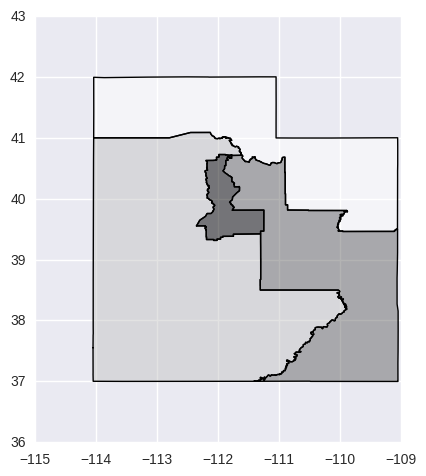

In [36]:
ut_cong_dist.plot()

In [39]:
ut_cong_dist.to_file('./fig/shapefile/cong_dist/ut_cong_dist.shp', driver="ESRI Shapefile")

# Clusters for UT

In [48]:
state_name = 'UT'
best_path = glob.glob('./clustered/best_stats/' + state_name +'*')[0]
best_basename = os.path.basename(best_path)
filename, file_extension = os.path.splitext(best_basename)
state = gpd.read_file(glob.glob('./clustered/geojson_results/' + filename +'.geojson')[0])

In [40]:
utah = state.dissolve(by='Cluster')

In [41]:
utah.to_file('./fig/shapefile/results/utah.shp', driver="ESRI Shapefile")